In [1]:
# Import libs
import os
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
from datetime import datetime
import importlib
import global_settings
importlib.reload(global_settings)

<module 'global_settings' from 'C:\\Users\\AO_HVN_ITS_LABO_DWH\\Desktop\\CHECK_CEDX\\global_settings.py'>

In [2]:
# Define root and temp folder that contain all needed file from code 1

setts = global_settings.Settings()

root_folder = setts.root_folder
#input_tmp_folder = root_folder + "/data"
input_folder = setts.input_folder
#output_folder = root_folder + "/data/tmp"
output_folder = setts.tmp1_folder

Directory found: D:\Software\temp\CeDX\data_2024_05/data
Directory found: D:\Software\temp\CeDX\data_2024_05/data/tmp
Directory found: D:\Software\temp\CeDX\data_2024_05/data/tmp2
Directory found: D:\Software\temp\CeDX\data_2024_05/output


In [3]:
def remove_non_numeric_chars(input_string):
    #return ''.join(char for char in input_string if char.isdigit())
    return setts.remove_non_numeric_chars(input_string)

def modify_phone_num_column(df, col):
#     df[col] = df[col].apply(lambda x: remove_non_numeric_chars(str(x))).dropna()
#     df = df[df[col] != '']
#     df[col] = df[col].astype(np.longlong).astype(str)
#     return df
    return setts.modify_phone_num_column(df, col)

In [4]:
# Read sales data
sales = pd.read_csv(input_folder + "/CeDX_Sale.csv")
sales['WARRANTY_START_DATE'] = sales['WARRANTY_START_DATE'].astype(str).str.replace('-', '').astype(int)
sales = sales[sales['WARRANTY_START_DATE'] <= setts.month_last]

# Drop the index column created from original file
sales = sales.drop('Unnamed: 0', errors='ignore', axis=1)
print(len(sales))
sales = sales[sales['WARRANTY_START_DATE'] != 0]
sales['WARRANTY_START_DATE'] = pd.to_datetime(sales['WARRANTY_START_DATE'], format='%Y%m%d')
print(len(sales))
# Calculate age based on date of birth
# If date of birth is 0 then age is nan
cal_year = 2022
sales['DATEOFBIRTH'] = sales['DATEOFBIRTH'].astype(str).str[:8]
sales['age'] = sales['DATEOFBIRTH'].astype(str).apply(lambda x: cal_year - int(x[:4]) if len(x) == 8 else np.nan)

# Convert value of DATEOFBIRTH column from yyyymmdd to yyyy-mm-dd
sales['DATEOFBIRTH'] = sales['DATEOFBIRTH'].astype(str).apply(lambda x: x[:4] + x[4:6] + x[:-2] if len(x) == 8 else np.nan)

C:\Users\AO_HVN_ITS_LABO_DWH\AppData\Local\Temp\ipykernel_23760\3810561738.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  sales = pd.read_csv(input_folder + "/CeDX_Sale.csv")


234385
234385


In [5]:
sales = sales.rename(columns = {'MOBILE_PHONE' : 'UID'})
sales = modify_phone_num_column(sales, 'UID')
sales = sales.dropna(subset=['UID'])

In [6]:
# PARTNER_CATEGORY == 1 is individual
sales = sales[sales['PARTNER_CATEGORY'] == 1]

# Count total puchase of each UID
sales['total_buy'] = sales.groupby('UID')['UID'].transform('count')

# Filter by WARRANTY_START_DATE==min(WARRANTY_START_DATE)
sales = sales[sales['WARRANTY_START_DATE'] == sales.groupby('UID')['WARRANTY_START_DATE'].transform('min')]
sales = sales.drop_duplicates()

# Count last buy of each UID
sales['last_buy_num'] = sales.groupby('UID')['UID'].transform('count')

# The number of time UID purchase 
sales['no'] = sales.groupby('UID').cumcount() + 1

# Year of the that purchase
sales['START_year'] = sales['WARRANTY_START_DATE'].dt.year


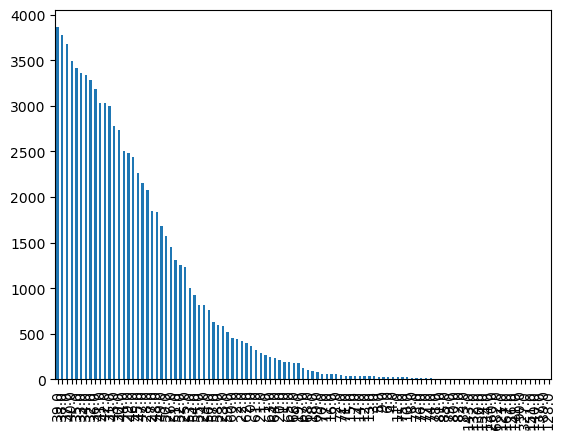

In [7]:
# Plot data by age
sales['age'].value_counts().plot(kind='bar')
sales_uni = sales[sales['no'] == 1]

# Default behaviour of R, trying to replicate it
sales['DATEOFBIRTH'] = sales['DATEOFBIRTH'].fillna("NA")
sales['SALES_PRICE'] = sales['SALES_PRICE'].fillna("NA")
sales['MARITAL_STATUS'] = sales['MARITAL_STATUS'].fillna("NA")

sales['age'] = sales['age'].fillna("NA")
sales['TITLE'] = sales['TITLE'].astype(str).apply(lambda x: x.lstrip('0') if x.strip() != '' else 'NA')
sales['MARITAL_STATUS'] = sales['MARITAL_STATUS'].astype(str).apply(lambda x: x.replace(' ', 'NA')).fillna("NA")

# Export data, remove .0 after all number


sales.to_csv(output_folder + '/sale_uni_min.csv', index=False)